In [ ]:
# Główny notebook: https://colab.research.google.com/drive/12VAlDscznXu-9wY2HiPzubACXdcNZRBs?usp=sharing#scrollTo=Dn5UT1xF7hMm
# Projektowy: https://colab.research.google.com/drive/18XektbqEegLaqQ1ZgaxVn4pYhJ8hJYiN?usp=sharing

# Roberta na bazie linków: 
# - https://jesusleal.io/2020/10/20/RoBERTA-Text-Classification/
# - https://colab.research.google.com/drive/1JJvzotINnD_JcMUO-Mv9fsTbJNhwGm5A?usp=sharing#scrollTo=BjlWeoMA-e_r

# 📚 Instalacja i import bibliotek

In [ ]:
!pip install 'transformers==4.12.5' 'tokenizers==0.10.3' 'sentencepiece==0.1.96' 'datasets==1.16.1' 'accelerate==0.5.1' 'sacremoses==0.0.46' 'sacrebleu==2.0.0' --quiet

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning --quiet
import pytorch_lightning as pl
print(pl.__version__)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
1.6.0dev


In [ ]:
import torch
import random
from torch import nn
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel, RobertaConfig, Trainer, TrainingArguments
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from transformers import GPT2Model, GPT2Tokenizer, GPT2ForSequenceClassification, set_seed, GPT2Config, AdamW, get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from transformers.modeling_outputs import SequenceClassifierOutputWithPast
import pytorch_lightning as pl
from torch.nn import MSELoss, CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import Dataset, DataLoader
import re, copy, logging, os
import argparse

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# ✏️ Funkcje pomocnicze

In [ ]:
def compute_metrics(pred):
    precision, recall, f1, _ = precision_recall_fscore_support(pred.label_ids,  pred.predictions.argmax(-1), average='binary')
    acc = accuracy_score(pred.label_ids, pred.predictions.argmax(-1))
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 📖 Wczytywanie danych

In [ ]:
LABEL_MAPPING = {
    0: 'negative',
    1: 'positive',
}

In [ ]:
data = load_dataset('rotten_tomatoes')

# Przemieszanie danych
data["train"] = data["train"].shuffle()
data

Using custom data configuration default
Reusing dataset rotten_tomatoes_movie_review (/root/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-d3c48477c383b351.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

## 📜 Przykładowe dane

In [ ]:
for i in range(0, 3):
  print(data["validation"][i]["text"])
  print(LABEL_MAPPING[data["validation"][i]["label"]] + "\n")

compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .
positive

the soundtrack alone is worth the price of admission .
positive

rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .
positive



# 🔨 Model 1: RobertaForSequenceClassification - Encoder


In [ ]:
class RobertaClassificationHeadROTTEN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size, 2 * config.hidden_size)
        self.dense_2 = nn.Linear(2 * config.hidden_size, 840)
        self.dense_3 = nn.Linear(840, 100)

        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )

        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(100, config.num_labels)

    def forward(self, features, **kwargs):
        x = features[:, 0, :]  # take <s> token (equiv. to [CLS])
        x = self.dropout(x)

        x = self.dense_1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.dense_2(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        
        x = self.dense_3(x)
        x = torch.tanh(x)
        x = self.dropout(x)

        x = self.out_proj(x)
        return x

class RobertaForSequenceClassificationROTTEN(RobertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = RobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHeadROTTEN(config)

        self.init_weights()

In [ ]:
model = RobertaForSequenceClassificationROTTEN.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassificationROTTEN: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassificationROTTEN from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassificationROTTEN from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassificationROTTEN were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.d

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = True, truncation=True)

train_data = data["train"].map(tokenization, batched = True, batch_size = len(data["train"]))
validation_data = data["validation"].map(tokenization, batched = True, batch_size = len(data["validation"]))
test_data = data["test"].map(tokenization, batched = True, batch_size = len(data["test"]))

train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
validation_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

test_data

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'input_ids', 'label', 'text'],
    num_rows: 1066
})

## ⚙️ RobertaForSequenceClassification: Trening

In [ ]:
training_args = TrainingArguments(
    output_dir = '/output',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/logs'
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data
)

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassificationROTTEN.forward` and have been ignored: text.
***** Running training *****
  Num examples = 8530
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1602


Step,Training Loss
500,0.546100
1000,0.435300
1500,0.307200


Saving model checkpoint to /output/checkpoint-500
Configuration saved in /output/checkpoint-500/config.json
Model weights saved in /output/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /output/checkpoint-1000
Configuration saved in /output/checkpoint-1000/config.json
Model weights saved in /output/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /output/checkpoint-1500
Configuration saved in /output/checkpoint-1500/config.json
Model weights saved in /output/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1602, training_loss=0.41950820537095657, metrics={'train_runtime': 951.1872, 'train_samples_per_second': 26.903, 'train_steps_per_second': 1.684, 'total_flos': 1076162670691200.0, 'train_loss': 0.41950820537095657, 'epoch': 3.0})

## 🐣 RobertaForSequenceClassification: Wyniki

In [ ]:
trainer.eval_dataset = test_data
test_RobertaForSequenceClassificationROTTEN  = trainer.evaluate()
print("WYNIKI DLA TEST DATASET:")
test_RobertaForSequenceClassificationROTTEN

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassificationROTTEN.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 64


WYNIKI DLA TEST DATASET:


{'epoch': 3.0,
 'eval_accuracy': 0.8611632270168855,
 'eval_f1': 0.859047619047619,
 'eval_loss': 0.37909573316574097,
 'eval_precision': 0.8723404255319149,
 'eval_recall': 0.8461538461538461,
 'eval_runtime': 8.7552,
 'eval_samples_per_second': 121.757,
 'eval_steps_per_second': 1.942}

In [ ]:
trainer.eval_dataset = validation_data
validation_RobertaForSequenceClassificationROTTEN = trainer.evaluate()
print("WYNIKI DLA VALIDATION DATASET:")
validation_RobertaForSequenceClassificationROTTEN

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassificationROTTEN.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1066
  Batch size = 64


WYNIKI DLA VALIDATION DATASET:


{'epoch': 3.0,
 'eval_accuracy': 0.8855534709193246,
 'eval_f1': 0.8872458410351202,
 'eval_loss': 0.3290802836418152,
 'eval_precision': 0.8743169398907104,
 'eval_recall': 0.900562851782364,
 'eval_runtime': 10.4669,
 'eval_samples_per_second': 101.845,
 'eval_steps_per_second': 1.624}

In [ ]:
for i in range(0, 10):
  index = random.randint(0, len(validation_data))
  label = validation_data["label"][index]
  input_ids =validation_data["input_ids"][i:i+1].to(device)
  pred = model(input_ids).logits.argmax(-1)[0]
  print(validation_data["text"][i])
  print(f"Label: {LABEL_MAPPING[int(label)]}\nPredicted: {LABEL_MAPPING[int(pred)]}\n\n")

compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .
Label: positive
Predicted: negative


the soundtrack alone is worth the price of admission .
Label: positive
Predicted: positive


rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .
Label: negative
Predicted: positive


beneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .
Label: positive
Predicted: negative


bielinsky is a filmmaker of impressive talent .
Label: positive
Predicted: positive


so beautifully acted and directed , it's clear that washington most certainly has a new career ahead of him if he so chooses .
Label: positive
Predicted: positive


a visual spectacle full of stunning images and effects .
Label: positive
Predicted: positive


a gentle and engrossing character

##🧹 RobertaForSequenceClassification: Zwalnianie pamięci

In [ ]:
trainer = None
model = None
torch.cuda.empty_cache()

# 🔨 Model 2: GPT2ForSequenceClassification - Decoder

**Main idea**: Since GPT2 is a decoder transformer, the last token of the input sequence is used to make predictions about the next token that should follow the input. This means that the last token of the input sequence contains all the information needed in the prediction. With this in mind we can use that information to make a prediction in a classification task instead of generation task.


In [ ]:
#Notebooki źródłowe:
#1. https://colab.research.google.com/drive/1JJvzotINnD_JcMUO-Mv9fsTbJNhwGm5A?usp=sharing#scrollTo=hrQguow-yXxE
#2. https://www.kaggle.com/baekseungyun/gpt-2-with-huggingface-pytorch/notebook

In [ ]:
class GPT2ClassificationHeadCustomSimple(nn.Module):
    def __init__(self, config):
        super().__init__()
        hidden_size = config.n_embd
        self.dense_1 = nn.Linear(hidden_size, 2 * hidden_size)
        self.dense_2 = nn.Linear(2 * hidden_size, hidden_size)
        self.dropout = nn.Dropout(config.resid_pdrop)
        self.out_proj = nn.Linear(hidden_size, config.num_labels, bias=False)

    def forward(self, x):
        x = self.dense_1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.dense_2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.out_proj(x)
        return x

class GPT2ForSequenceClassificationCustomSimple(GPT2ForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.transformer = GPT2Model(config)
        self.score = GPT2ClassificationHeadCustom(config)

        self.init_weights()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

In [ ]:
class GPT2ClassificationHeadCustom(nn.Module):
    def __init__(self, config):
        super().__init__()
        hidden_size = config.n_embd
        self.dense_1_input = nn.Linear(hidden_size, 2 * hidden_size)
        self.dense_1_hidden = nn.Linear(hidden_size, 2 * hidden_size)
        self.dense_2 = nn.Linear(4 * hidden_size, hidden_size)
        self.dropout = nn.Dropout(config.resid_pdrop)
        self.out_proj = nn.Linear(hidden_size, config.num_labels, bias=False)

    def forward(self, x, **kwargs):
        if 'hidden_states' in kwargs and kwargs['hidden_states'] is not None:
            # Get hidden states from last layer
            hidden = kwargs['hidden_states'][-1]
        else:
            hidden = torch.zeros(x.size(), dtype=x.dtype, device=x.device)

        x = self.dense_1_input(x)
        x = torch.relu(x)
        x = self.dropout(x)

        hidden = self.dense_1_hidden(hidden)
        hidden = torch.relu(hidden)
        hidden = self.dropout(hidden)

        x = torch.cat((x, hidden), dim=2)
        x = self.dense_2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.out_proj(x)
        return x

In [ ]:
def train(dataloader, optimizer, scheduler, device_):
    global model
    model.train()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        
        outputs = model(**batch)
        loss, logits = outputs[:2]
        logits = logits.detach().cpu().numpy()
        total_loss.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent exploding gradient

        optimizer.step()
        scheduler.step()
        
        prediction_labels += logits.argmax(axis=-1).flatten().tolist()
    
    return true_labels, prediction_labels, total_loss

def validation(dataloader, device_):
    global model
    model.eval()
    
    prediction_labels = []
    true_labels = []
    
    total_loss = []
    
    for batch in dataloader:
        true_labels += batch['labels'].numpy().flatten().tolist()
        batch = {k:v.type(torch.long).to(device_) for k, v in batch.items()}
        
        with torch.no_grad():
            outputs = model(**batch)
            loss, logits = outputs[:2]
            logits = logits.detach().cpu().numpy()
            total_loss.append(loss.item())

            prediction_labels += logits.argmax(axis=-1).flatten().tolist()
        
    return true_labels, prediction_labels, total_loss

class Gpt2ClassificationCollator(object):
    def __init__(self, tokenizer, max_seq_len=None):
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
        
        return
    
    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [int(sequence['label']) for sequence in sequences]
        inputs = self.tokenizer(text=texts,
                                return_tensors='pt',
                                padding=True,
                                truncation=True,
                                max_length=self.max_seq_len)
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

In [ ]:
set_seed(2022022)

#model_config = GPT2Config.from_pretrained('gpt2', num_labels=2) # Binary Classification
#model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

model = GPT2ForSequenceClassificationCustomSimple.from_pretrained('gpt2-medium')

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = model.config.eos_token_id

gpt2classificationcollator = Gpt2ClassificationCollator(tokenizer=tokenizer,
                                                        max_seq_len=80)

Some weights of GPT2ForSequenceClassificationCustomSimple were not initialized from the model checkpoint at gpt2-medium and are newly initialized: ['score.dense_1_input.weight', 'score.dense_1_input.bias', 'score.dense_2.weight', 'score.out_proj.weight', 'score.dense_2.bias', 'score.dense_1_hidden.bias', 'score.dense_1_hidden.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=data["train"],
                              batch_size=16,
                              shuffle=True,
                              collate_fn=gpt2classificationcollator)
val_dataloader = DataLoader(dataset=data["validation"],
                            batch_size=32,
                            shuffle=False,
                            collate_fn=gpt2classificationcollator)
test_dataloader = DataLoader(dataset=data["test"],
                             batch_size=32,
                             shuffle=False,
                             collate_fn=gpt2classificationcollator)

In [ ]:
total_epochs = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,
                  lr=1e-4,
                  eps=1e-8)

num_train_steps = len(train_dataloader) * total_epochs
num_warmup_steps = int(num_train_steps * 0.1) 

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=num_warmup_steps,
                                               num_training_steps = num_train_steps)

## ⚙️ GPT2ForSequenceClassification: Trening

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

all_loss = {'train_loss': [], 'val_loss': [], 'test_loss': []}
all_acc = {'train_acc': [],  'val_acc': [], 'test_acc': []}

for epoch in range(total_epochs):
    y, y_pred, train_loss = train(train_dataloader, optimizer, lr_scheduler, device)
    train_acc = accuracy_score(y, y_pred)
    
    y, y_pred, val_loss = validation(val_dataloader, device)
    val_acc = accuracy_score(y, y_pred)

    y, y_pred, test_loss = validation(test_dataloader, device)
    test_acc = accuracy_score(y, y_pred)
    
    all_loss['train_loss'] += train_loss
    all_loss['val_loss'] += val_loss
    all_loss['test_loss'] += test_loss
    
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)
    all_acc['test_acc'].append(test_acc)

    
    
    print(f'Epoch: {epoch}, train_loss: {torch.tensor(train_loss).mean():.3f}, train_acc: {train_acc:.3f}, val_loss: {torch.tensor(val_loss).mean():.3f}, val_acc: {val_acc:.3f}, test_loss: {torch.tensor(test_loss).mean():.3f}, test_acc: {test_acc:.3f}') 

Epoch: 0, train_loss: 0.541, train_acc: 0.734, val_loss: 0.547, val_acc: 0.741, test_loss: 0.545, test_acc: 0.725
Epoch: 1, train_loss: 0.487, train_acc: 0.772, val_loss: 0.730, val_acc: 0.687, test_loss: 0.625, test_acc: 0.735
Epoch: 2, train_loss: 0.394, train_acc: 0.828, val_loss: 0.625, val_acc: 0.731, test_loss: 0.551, test_acc: 0.745
Epoch: 3, train_loss: 0.326, train_acc: 0.867, val_loss: 0.870, val_acc: 0.713, test_loss: 0.775, test_acc: 0.736
Epoch: 4, train_loss: 0.263, train_acc: 0.894, val_loss: 1.027, val_acc: 0.723, test_loss: 0.921, test_acc: 0.753
Epoch: 5, train_loss: 0.214, train_acc: 0.919, val_loss: 1.193, val_acc: 0.703, test_loss: 1.135, test_acc: 0.735
Epoch: 6, train_loss: 0.186, train_acc: 0.931, val_loss: 1.011, val_acc: 0.714, test_loss: 0.916, test_acc: 0.739
Epoch: 7, train_loss: 0.160, train_acc: 0.943, val_loss: 1.247, val_acc: 0.711, test_loss: 1.118, test_acc: 0.745


## 🐣 GPT2ForSequenceClassification: Wyniki

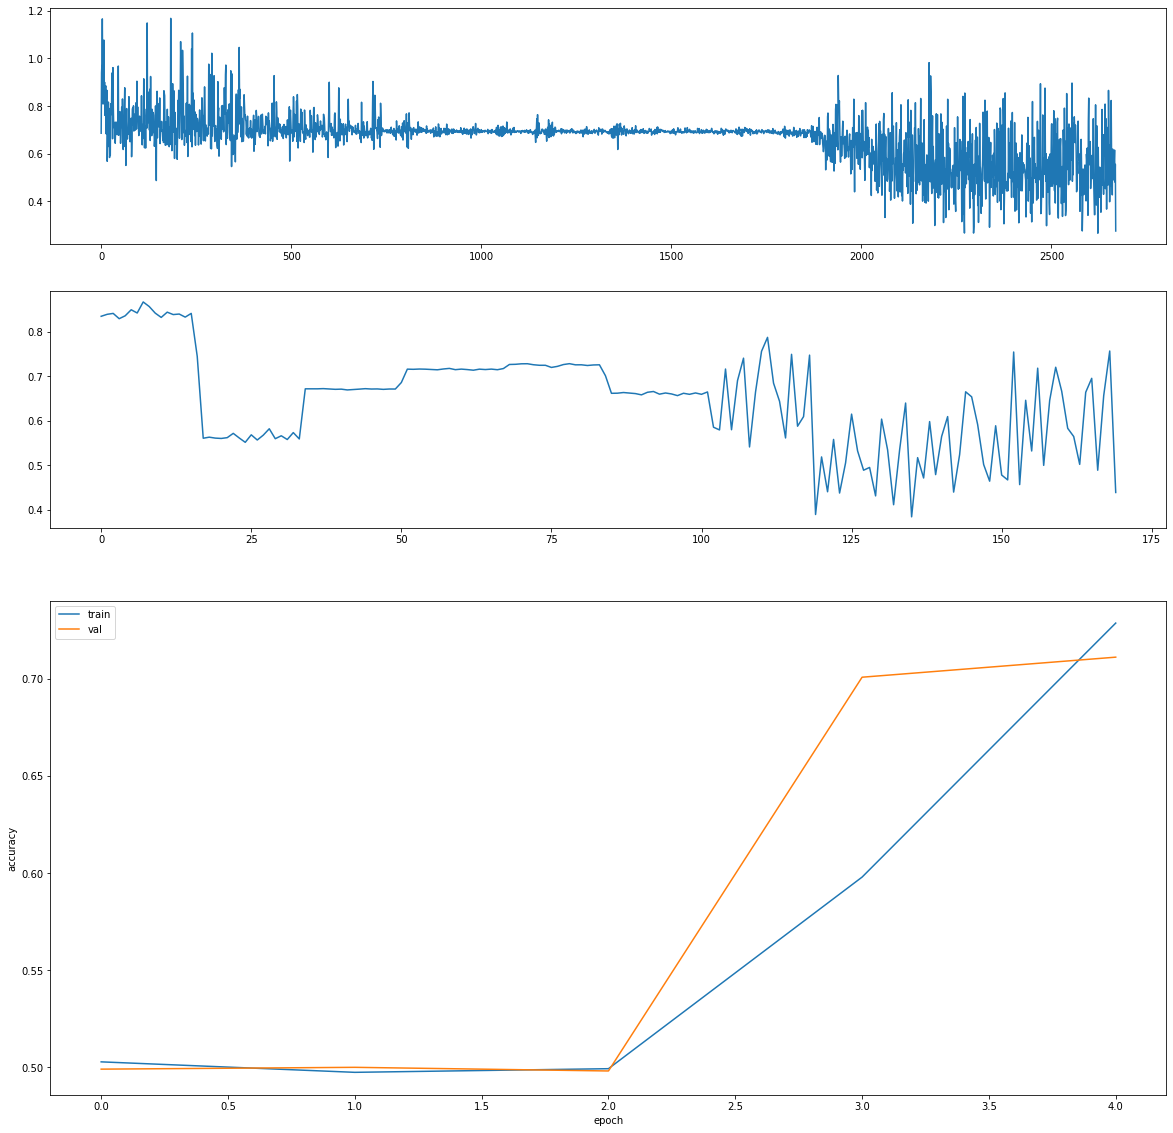

In [ ]:
fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(4, 1, 1)
b = fig.add_subplot(4, 1, 2)
c = fig.add_subplot(2, 1, 2)
a.plot(all_loss['train_loss'])
b.plot(all_loss['val_loss'])
c.plot(all_acc['train_acc'])
c.plot(all_acc['val_acc'])
c.set(xlabel='epoch', ylabel='accuracy')
c.legend(['train', 'val'])

pass

In [ ]:
S_, test_pred, _ = validation(test_dataloader, device)

test_pred

##🧹 T5ForConditionalGeneration: Zwalnianie pamięci

# 🔨 Model 3: T5ForConditionalGeneration - Encoder-Decoder

In [ ]:
class RottenTomatoesDataset(Dataset):
  def __init__(self, tokenizer, rotten_data,  max_len=512):
    self.data = rotten_data
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()
    src_mask    = self.inputs[index]["attention_mask"].squeeze()
    target_mask = self.targets[index]["attention_mask"].squeeze()
    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    for row in self.data:
      sentiment = LABEL_MAPPING[row["label"]]
      line = row["text"].strip()
      line = REPLACE_NO_SPACE.sub("", line) 
      line = REPLACE_WITH_SPACE.sub("", line)
      line = line + ' </s>'
      target = sentiment + " </s>"
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [line], max_length=self.max_len, truncation=True, padding=True, return_tensors="pt"
      )
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=3, truncation=True, return_tensors="pt"
      )
      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

def get_dataset(tokenizer, type_path, args):
  return RottenTomatoesDataset(tokenizer=tokenizer, rotten_data=data[type_path],  max_len=args.max_seq_len)

In [ ]:
# Zmodyfikowany kod z: https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    for key in hparams.keys():
            self.hparams[key]=hparams[key]
    self.model = T5ForConditionalGeneration.from_pretrained(self.hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(self.hparams.tokenizer_name_or_path)

  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    print(lm_labels)
    print(input_ids)

    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100
    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )
    loss = outputs[0]
    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)
    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [ ]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))

## ⚙️ T5ForConditionalGeneration: Trening

In [ ]:
args_dict = dict(
    output_dir="t5_rotten_sentiment",
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_len=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1 if device=="cuda" else 0,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42
)

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=5)

train_params = dict(
    accumulate_grad_batches=args_dict["gradient_accumulation_steps"],
    gpus=args_dict["n_gpu"],
    max_epochs=args_dict["num_train_epochs"],
    precision= 16 if args_dict["fp_16"] else 32,
    gradient_clip_val=args_dict["max_grad_norm"],
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()]
)
model = T5FineTuner(args_dict)

trainer = pl.Trainer(**train_params)
trainer.fit(model)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:143: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f968b0b1d90>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f968b0b1d90>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:110: UserWarning: When using `Trainer(accumulate_grad_batches != 1)` and overriding `LightningModule.optimizer_{step,zero_grad}`, the hooks will not be called on every batch (rather, they are called on every optimization step).
  "When using `Tra

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5.py:191: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  f"This sequence already has {self.eos_token}. In future versions this behavior may lead to duplicated eos tokens being added."
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

## 🐣 T5ForConditionalGeneration: Wyniki

In [ ]:
def predict_sentiment(text):
  input = task_prefix + text
  input = tokenizer.encode_plus(input, return_tensors="pt").to(device)
  outputs = model.generate(**input)
  return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
input_sentece = "efficient suitably anonymous chiller"
print(predict_sentiment(input_sentece))

sentiment: efficient suitably anonymous chiller: efficient suitably anonymous chiller: efficient suit


##🧹 T5ForConditionalGeneration: Zwalnianie pamięci

In [ ]:
input_ids = None
target_ids = None
outputs = None
input_sentece = None
training_sentences = None
training_labels = None

tokenizer = None
model = None
torch.cuda.empty_cache()

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

<pad> positive</s>
<pad> negative</s>
